In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import sqrt
import pandas as pd
import scipy.constants as const
from scipy.optimize import curve_fit                        # Funktionsfit:     popt, pcov = curve_fit(func, xdata, ydata) 
from uncertainties import ufloat                            # Fehler:           fehlerwert =  ulfaot(x, err)
from uncertainties import unumpy as unp 
from uncertainties.unumpy import uarray                     # Array von Fehler: fehlerarray =  uarray(array, errarray)
from uncertainties.unumpy import (nominal_values as noms,   # Wert:             noms(fehlerwert) = x
                                  std_devs as stds)         # Abweichung:       stds(fehlerarray) = errarray

Tabelle erstellen:

In [33]:
Ua = pd.read_csv('tables/spannung.csv')
print(Ua.to_latex(index = False, column_format= "c c", decimal=',')) 

\begin{tabular}{c c}
\toprule
 f/kHz &   U/V \\
\midrule
  20,0 & 0,085 \\
  22,5 & 0,110 \\
  25,0 & 0,150 \\
  27,0 & 0,190 \\
  30,0 & 0,310 \\
  32,8 & 0,800 \\
  33,3 & 1,200 \\
  34,1 & 1,900 \\
  35,4 & 2,000 \\
  36,0 & 1,600 \\
  36,9 & 0,840 \\
  38,3 & 0,530 \\
  39,3 & 0,410 \\
\bottomrule
\end{tabular}



Daten auswerten:

a = 1.98+/-0.15
b = 6.1+/-1.2
nu0 = 34.951628731739696
U0 = 1.9786035046198864


(22.0, 40.0)

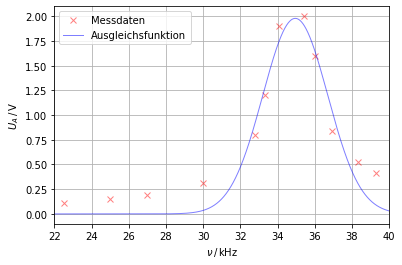

In [46]:
np.savetxt('tables/Ua.txt', Ua.values, header='f/Hz U/V', fmt='%.3f')
nu, U = np.genfromtxt('tables/Ua.txt', unpack=True, skip_header=1)

plt.plot(nu, U, 'xr', markersize=6 , label = 'Messdaten', alpha=0.5)

# für den initial guess bei curvefit()
n = len(nu)                              #the number of data
mean = sum(nu*U)/n                       #note this correction
# sigma = sum(U*(nu - mean)**2)/n        #note this correction
sigma = np.sqrt(sum(U*(nu - mean)**2))

# Ausgleichsrechung nach Gaußverteilung
def g(x,a,x0,b):
    return a*np.exp(-(x-x0)**2/(b)) # b = 2*sigma**2

para, pcov = curve_fit(g, nu, U, p0=[1,mean,sigma])
a, nu0, b = para
pcov = np.sqrt(np.diag(pcov))
fa, fnu0, fb = pcov

# Fehler der Parameter
ua = ufloat(a, fa) 
ub = ufloat(b, fb)
unu0 = ufloat(nu0, fnu0)
print('a =', ua)
print('b =', ub)
print('nu0 =', nu0)
print('U0 =', g(nu0, a, nu0, b))

xx = np.linspace(18, 42, 10**4)
plt.plot(xx, g(xx, *para), '-b', linewidth = 1, label = 'Ausgleichsfunktion', alpha=0.5)

plt.xlabel(r'$\nu \, / \, \mathrm{kHz}$')
plt.ylabel(r'$U_A \, / \, \mathrm{V}$')
plt.legend(loc="best")                  # legend position
plt.grid(True)                          # grid style
plt.xlim(22, 40)

Fehler berechnen:

In [ ]:
ua = ufloat(a, fa) 
print('T = (%.3f ± %.3f)' % (noms(ua), stds(ua)))

NameError: name 'a' is not defined

Plot erstellen:

In [ ]:

plt.plot(f, Uc, 'xr', markersize=6 , label = 'Messdaten', alpha=0.5)
xx = np.linspace(100, 150000, 10**4)
plt.plot(xx, g(xx, a), '-b', linewidth = 1, label = 'Ausgleichsfunktion')

plt.xlabel(r'$f \, / \, \mathrm{Hz}$')
plt.ylabel(r'$A(\omega) \, / \, U_0$')
plt.xscale('log')                       # axis scale 
plt.legend(loc="best")                  # legend position
plt.grid(True)                          # grid style
plt.xlim(200, 150000)                   # limitation of visible scale in plot

NameError: name 'f' is not defined